In [1]:
import pandas as pd
import re
import os 
import glob
import numpy as np
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
def remove_files_with_specific_content(file_list, pattern):
    # Loop over each file and check for the specific content
    for file_path in file_list:
        try:
            with open(file_path, 'r') as file:
                content = file.read()
                if pattern in content:
                    os.remove(file_path)
                    print(f"Removed file: {file_path}")
        except Exception as e:
            print(f"Failed to process file {file_path}: {e}")

In [4]:
def extract_data(path):
    # Read the file
    with open(path, 'r') as file:
        lines = file.readlines()

    # Extract experiment parameters
    params_line = lines[0]
    params = re.search(r'Args \{ (.*) \}', params_line).group(1)
    params_dict = dict(item.split(": ") for item in params.replace('"','').split(', '))
    for key, value in params_dict.items():
        try:
            params_dict[key] = eval(value)
        except:
            pass
    params_dict["optimal"] = False
    params_dict["path"] = path

    # if params_dict["max_level"] > 0.5:
    #     print(f"{path} has firing rate {params_dict['firing_rate']}")

    # Initialize lists to store data
    neurons_data = []
    spectral_radius = None
    simulation_results = {}

    # Extract data for each neuron and other required information
    for line in lines:
        if "ptimization succeeded" in line:
            neuron_data = re.search(r'Neuron (\d+): .* succeeded in (\d+) .* All (\d+) .* final cost of ([\d.]+).', line)
            if neuron_data:
                neuron_id, iterations, constraints, final_cost = neuron_data.groups()
                neurons_data.append({
                    'neuron_id': int(neuron_id),
                    'iterations': int(iterations),
                    'constraints': int(constraints),
                    'final_cost': float(final_cost)
                })
        elif "expected number of spikes" in line:
            spikes_data = re.search(r'(\d+) spikes sampled over', line)
            if spikes_data:
                num_spikes, *_ = spikes_data.groups()
                params_dict["num_spikes"] = int(num_spikes)
        elif "Memorization done" in line:
            params_dict["optimal"] = True
        elif "Spectral radius:" in line:
            spectral_data = re.search(r'Spectral radius: ([\d.e+-]+) \(([\d.e+-]+) per spikes and ([\d.e+-]+) per period\)', line)
            if spectral_data:
                spectral_radius, spectral_radius_per_spike, spectral_radius_per_period = spectral_data.groups()
                simulation_results['spectral_radius'] = float(spectral_radius)
                simulation_results['spectral_radius_per_spike'] = float(spectral_radius_per_spike)
                simulation_results['spectral_radius_per_period'] = float(spectral_radius_per_period)
        elif "After 50 cycles" in line:
            simulation_data = re.search(r'precision and recall are ([\d.]+) and ([\d.  ]+) \(w/ (\d+)% threshold noise\)', line)
            if simulation_data:
                precision, recall, noise = simulation_data.groups()
                simulation_results[f'precision_{int(noise)}'] = float(precision)
                simulation_results[f'recall_{int(noise)}'] = float(recall)

    # Create DataFrame
    df_params = pd.DataFrame([params_dict])
    df_neurons = pd.DataFrame(neurons_data)
    df_simulation = pd.DataFrame([simulation_results])

    # Combine all data into a single DataFrame
    df_neurons = pd.merge(df_params, df_neurons, how='cross')
    if df_simulation.empty:
        df_network = df_params
    else:
        df_network = pd.merge(df_params, df_simulation, how='cross')

    return df_network, df_neurons

In [5]:
file_list = glob.glob(os.path.join('exp', 'err*'))
remove_files_with_specific_content(file_list, "error: a value is required for '--period <PERIOD>' but none was supplied")
file_list = glob.glob(os.path.join('exp', 'err*'))
remove_files_with_specific_content(file_list, "error: unexpected argument '--firing_rate' found")

In [6]:
df1, df2 = extract_data("log/64bedcc1bfe483c92d8a5b33af15f316cf0f9b1e00dcbda070f1244faaee2052.log")
df2.head()

,seed,num_neurons,num_inputs,lim_weight,min_delay,max_delay,period,firing_rate,max_level,min_slope,half_width,objective,optimal,path,num_spikes,neuron_id,iterations,constraints,final_cost
0,1,200,500,1.0,0.1,10.0,50.0,0.5,0.0,2.0,0.2,l1,True,log/64bedcc1bfe483c92d8a5b33af15f316cf0f9b1e00...,2577,93,44,97,18.107675
1,1,200,500,1.0,0.1,10.0,50.0,0.5,0.0,2.0,0.2,l1,True,log/64bedcc1bfe483c92d8a5b33af15f316cf0f9b1e00...,2577,75,44,100,18.587357
2,1,200,500,1.0,0.1,10.0,50.0,0.5,0.0,2.0,0.2,l1,True,log/64bedcc1bfe483c92d8a5b33af15f316cf0f9b1e00...,2577,0,49,102,18.004084
3,1,200,500,1.0,0.1,10.0,50.0,0.5,0.0,2.0,0.2,l1,True,log/64bedcc1bfe483c92d8a5b33af15f316cf0f9b1e00...,2577,96,53,112,18.081230
4,1,200,500,1.0,0.1,10.0,50.0,0.5,0.0,2.0,0.2,l1,True,log/64bedcc1bfe483c92d8a5b33af15f316cf0f9b1e00...,2577,87,50,114,21.041118


In [7]:
file_list = glob.glob(os.path.join('log', '*.log'))
list_of_neuron_data = []
list_of_network_data = []

# Loop over each file and process it
for file_path in file_list:
    try:
        df_network, _ = extract_data(file_path)
        list_of_network_data.append(df_network)
        # print(f"Data from {file_path} extracted successfully")
    except Exception as e:
        print(f"Failed to extract data from {file_path}: {e}")
        continue


# Combine all network data into a single DataFrame
df_network = pd.concat(list_of_network_data)

# Drop duplicates
df_network = df_network.drop_duplicates(['seed', 'period', 'firing_rate', 'num_neurons', 'num_inputs', 'objective', 'min_slope', 'max_level', 'lim_weight'])
df_network["optimal_and_stable"] = df_network["optimal"] & (df_network["precision_2"] > 0.9) & (df_network["recall_2"] > 0.9)

# Loop over each file and process it
for file_path in df_network['path']:
    try:
        _, df_neurons = extract_data(file_path)
        list_of_neuron_data.append(df_neurons)
        # print(f"Data from {file_path} extracted successfully")
    except Exception as e:
        print(f"Failed to extract data from {file_path}: {e}")
        continue

# Combine all neuron data into a single DataFrame
df_neurons = pd.concat(list_of_neuron_data)

df_neurons_agg = df_neurons.groupby(['seed', 'period', 'firing_rate', 'num_neurons', 'num_inputs', 'objective', 'min_slope', 'max_level', 'lim_weight']).agg({'iterations': 'mean',	'constraints':'mean', 'final_cost':'mean'}).reset_index()
df_neurons_agg['final_cost'] = df_neurons_agg['final_cost'] / df_neurons_agg['num_inputs']

df_network = df_network.merge(df_neurons_agg, on=['seed', 'period', 'firing_rate', 'num_neurons', 'num_inputs', 'objective', 'min_slope', 'max_level', 'lim_weight'])
df_network.loc[df_network.optimal == False, 'final_cost'] = np.nan
df_network.loc[df_network.optimal == False, 'iterations'] = np.nan
df_network.loc[df_network.optimal == False, 'constraints'] = np.nan
df_network.head()

,seed,num_neurons,num_inputs,lim_weight,min_delay,max_delay,period,firing_rate,max_level,min_slope,half_width,objective,optimal,path,num_spikes,spectral_radius,spectral_radius_per_spike,spectral_radius_per_period,precision_2,recall_2,precision_5,recall_5,precision_10,recall_10,precision_20,recall_20,optimal_and_stable,iterations,constraints,final_cost
0,4,200,600,0.2,0.1,10.0,90.0,0.2,0.0,2.0,0.2,l2,True,log/7812e6312fd6a5ee3bc02135f49943269cb3f5879c...,2578,6.219763e-07,0.994472,0.853182,0.991313,0.991313,0.979161,0.979161,0.951790,0.951790,NaN,NaN,True,44.610,96.940,0.008455
1,6,200,600,0.2,0.1,10.0,105.0,0.5,0.0,2.0,0.2,l2,True,log/eb398480ddd2b784627926a4344b50fa166c324728...,5478,1.591749e-05,0.997985,0.900127,0.990531,0.990531,0.976366,0.976366,0.951353,0.951353,NaN,NaN,True,96.730,209.340,0.012773
2,1,200,600,0.2,0.1,10.0,110.0,1.0,0.0,2.0,0.2,l2,False,log/5df2fa0fbd9b32931a030b0a7613b25f0789871cb1...,7919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN
3,10,200,600,0.2,0.1,10.0,110.0,0.2,0.0,2.0,0.2,l2,True,log/05cb2f8a68a8130deef129dc1311f6fa58ccfdd542...,3155,9.134270e-07,0.995602,0.881246,0.991618,0.991618,0.976765,0.976765,0.953649,0.953649,NaN,NaN,True,55.680,121.795,0.010879
4,9,200,500,0.2,0.1,10.0,50.0,10.0,0.0,2.0,0.2,l2,True,log/5e5d353310571acc113f95d398983e061b278bc23d...,6406,6.725898e-02,0.999579,0.947447,0.987929,0.987929,0.972733,0.972733,0.947178,0.947020,0.335595,0.245024,True,127.505,225.145,0.010741


In [8]:
# Assuming network_df is already defined and contains the necessary data
# Group by the specified parameters
default = (df_network['period'] == 50.0) & (df_network['firing_rate'] == 0.5) & (df_network['num_neurons'] == 200) & (df_network['num_inputs'] == 500) & (df_network['objective'] == "l2") & (df_network['min_slope'] == 2.0) & (df_network['max_level'] == 0.0) & (df_network['lim_weight'] == 0.2)

# Number of Neurons vs Number of Inputs

In [9]:
filter = (df_network['period'] == 50.0) & (df_network['firing_rate'] == 0.5) & (df_network['num_inputs'] == 500) & (df_network['objective'] == "l2") & (df_network['min_slope'] == 2.0) & (df_network['lim_weight'] == 0.2) & (df_network['max_level'] == 0.0)
filtered = df_network[filter]

In [10]:
# Aggregate the data
aggregated = filtered.groupby(['num_neurons']).agg(
    num_experiments=('optimal', 'count'),
    mean_optimal=('optimal', 'mean'),
    mean_iterations=('iterations', 'mean'),
    mean_constraints=('constraints', 'mean'),
    mean_final_cost=('final_cost', 'mean'),
    min_spectral_radius_per_spike=('spectral_radius_per_spike', 'min'),
    max_spectral_radius_per_spike=('spectral_radius_per_spike', 'max'),
    min_spectral_radius_per_period=('spectral_radius_per_period', 'min'),
    max_spectral_radius_per_period=('spectral_radius_per_period', 'max'),
    # median_normalized_spectral_radius=('normalized_spectral_radius', 'median'),
    # mean_normalized_spectral_radius=('normalized_spectral_radius', 'mean'),
    # min_precision_0=('precision_0', 'min'),
    # median_precision_0=('precision_0', 'median'),
    # max_precision_0=('precision_0', 'max'),
    # mean_precision_0=('precision_0', 'mean'),
    # min_recall_0=('recall_0', 'min'),
    # median_recall_0=('recall_0', 'median'),
    # max_recall_0=('recall_0', 'max'),
    # mean_recall_0=('recall_0', 'mean'),
    # min_precision_1=('precision_1', 'min'),
    # median_precision_1=('precision_1', 'median'),
    # max_precision_1=('precision_1', 'max'),
    # # mean_precision_1=('precision_1', 'mean'),
    # min_recall_1=('recall_1', 'min'),
    # median_recall_1=('recall_1', 'median'),
    # max_recall_1=('recall_1', 'max'),
    # mean_recall_1=('recall_1', 'mean'),
    min_precision_2=('precision_2', 'min'),
    median_precision_2=('precision_2', 'median'),
    max_precision_2=('precision_2', 'max'),
    # mean_precision_2=('precision_2', 'mean'),
    min_recall_2=('recall_2', 'min'),
    median_recall_2=('recall_2', 'median'),
    max_recall_2=('recall_2', 'max'),
    # mean_recall_2=('recall_2', 'mean'),
    min_precision_5=('precision_5', 'min'),
    median_precision_5=('precision_5', 'median'),
    max_precision_5=('precision_5', 'max'),
    # mean_precision_5=('precision_5', 'mean'),
    min_recall_5=('recall_5', 'min'),
    median_recall_5=('recall_5', 'median'),
    max_recall_5=('recall_5', 'max'),
    # mean_recall_5=('recall_5', 'mean'),
    min_precision_10=('precision_10', 'min'),
    median_precision_10=('precision_10', 'median'),
    max_precision_10=('precision_10', 'max'),
    # mean_precision_10=('precision_10', 'mean'),
    min_recall_10=('recall_10', 'min'),
    median_recall_10=('recall_10', 'median'),
    max_recall_10=('recall_10', 'max'),
    # mean_recall_10=('recall_10', 'mean')
).reset_index().round(3)

In [11]:
aggregated.head(10)

,num_neurons,num_experiments,mean_optimal,mean_iterations,mean_constraints,mean_final_cost,min_spectral_radius_per_spike,max_spectral_radius_per_spike,min_spectral_radius_per_period,max_spectral_radius_per_period,min_precision_2,median_precision_2,max_precision_2,min_recall_2,median_recall_2,max_recall_2,min_precision_5,median_precision_5,max_precision_5,min_recall_5,median_recall_5,max_recall_5,min_precision_10,median_precision_10,max_precision_10,min_recall_10,median_recall_10,max_recall_10
0,10,9,0.889,46.975,100.388,0.008,0.952,0.969,0.892,0.923,0.989,0.990,0.992,0.989,0.990,0.992,0.970,0.978,0.981,0.970,0.978,0.981,0.127,0.156,0.953,0.127,0.156,0.953
1,50,10,1.000,44.346,93.380,0.007,0.989,0.990,0.865,0.883,0.990,0.991,0.992,0.990,0.991,0.992,0.978,0.979,0.980,0.978,0.979,0.980,0.953,0.957,0.960,0.953,0.957,0.960
2,100,10,1.000,44.088,92.569,0.007,0.994,0.995,0.863,0.871,0.991,0.991,0.992,0.991,0.991,0.992,0.978,0.979,0.980,0.978,0.979,0.980,0.956,0.957,0.959,0.956,0.957,0.959
3,200,10,1.000,44.467,93.143,0.007,0.997,0.997,0.861,0.869,0.991,0.991,0.992,0.991,0.991,0.992,0.978,0.979,0.980,0.978,0.979,0.980,0.956,0.958,0.959,0.956,0.958,0.959
4,500,10,1.000,44.108,92.544,0.007,0.999,0.999,0.860,0.863,0.991,0.991,0.992,0.991,0.991,0.992,0.978,0.979,0.980,0.978,0.979,0.980,0.957,0.958,0.959,0.957,0.958,0.959
5,1000,10,1.000,44.303,92.828,0.007,0.999,0.999,0.861,0.863,0.991,0.991,0.992,0.991,0.991,0.992,0.979,0.979,0.979,0.979,0.979,0.979,0.957,0.958,0.958,0.957,0.958,0.958


# Template Matching - Parameters Analysis

## Maximum Level

In [12]:
filter = (df_network['period'] == 50.0) & (df_network['firing_rate'] == 0.5) & (df_network['num_neurons'] == 200) & (df_network['num_inputs'] == 500) & (df_network['objective'] == "l2") & (df_network['min_slope'] == 2.0) & (df_network['lim_weight'] == 0.2)
filtered = df_network[filter]

In [13]:
# Aggregate the data
aggregated = filtered.groupby(['max_level']).agg(
    num_experiments=('optimal', 'count'),
    mean_optimal=('optimal', 'mean'),
    mean_iterations=('iterations', 'mean'),
    mean_constraints=('constraints', 'mean'),
    mean_final_cost=('final_cost', 'mean'),
    min_spectral_radius_per_spike=('spectral_radius_per_spike', 'min'),
    max_spectral_radius_per_spike=('spectral_radius_per_spike', 'max'),
    min_spectral_radius_per_period=('spectral_radius_per_period', 'min'),
    max_spectral_radius_per_period=('spectral_radius_per_period', 'max'),
    # median_normalized_spectral_radius=('normalized_spectral_radius', 'median'),
    # mean_normalized_spectral_radius=('normalized_spectral_radius', 'mean'),
    # min_precision_0=('precision_0', 'min'),
    # median_precision_0=('precision_0', 'median'),
    # max_precision_0=('precision_0', 'max'),
    # mean_precision_0=('precision_0', 'mean'),
    # min_recall_0=('recall_0', 'min'),
    # median_recall_0=('recall_0', 'median'),
    # max_recall_0=('recall_0', 'max'),
    # mean_recall_0=('recall_0', 'mean'),
    # min_precision_1=('precision_1', 'min'),
    # median_precision_1=('precision_1', 'median'),
    # max_precision_1=('precision_1', 'max'),
    # # mean_precision_1=('precision_1', 'mean'),
    # min_recall_1=('recall_1', 'min'),
    # median_recall_1=('recall_1', 'median'),
    # max_recall_1=('recall_1', 'max'),
    # mean_recall_1=('recall_1', 'mean'),
    min_precision_2=('precision_2', 'min'),
    median_precision_2=('precision_2', 'median'),
    max_precision_2=('precision_2', 'max'),
    # mean_precision_2=('precision_2', 'mean'),
    min_recall_2=('recall_2', 'min'),
    median_recall_2=('recall_2', 'median'),
    max_recall_2=('recall_2', 'max'),
    # mean_recall_2=('recall_2', 'mean'),
    min_precision_5=('precision_5', 'min'),
    median_precision_5=('precision_5', 'median'),
    max_precision_5=('precision_5', 'max'),
    # mean_precision_5=('precision_5', 'mean'),
    min_recall_5=('recall_5', 'min'),
    median_recall_5=('recall_5', 'median'),
    max_recall_5=('recall_5', 'max'),
    # mean_recall_5=('recall_5', 'mean'),
    min_precision_10=('precision_10', 'min'),
    median_precision_10=('precision_10', 'median'),
    max_precision_10=('precision_10', 'max'),
    # mean_precision_10=('precision_10', 'mean'),
    min_recall_10=('recall_10', 'min'),
    median_recall_10=('recall_10', 'median'),
    max_recall_10=('recall_10', 'max'),
    # mean_recall_10=('recall_10', 'mean')
).reset_index().round(3)

In [14]:
aggregated.head(10)

,max_level,num_experiments,mean_optimal,mean_iterations,mean_constraints,mean_final_cost,min_spectral_radius_per_spike,max_spectral_radius_per_spike,min_spectral_radius_per_period,max_spectral_radius_per_period,min_precision_2,median_precision_2,max_precision_2,min_recall_2,median_recall_2,max_recall_2,min_precision_5,median_precision_5,max_precision_5,min_recall_5,median_recall_5,max_recall_5,min_precision_10,median_precision_10,max_precision_10,min_recall_10,median_recall_10,max_recall_10
0,0.0,10,1.0,44.467,93.143,0.007,0.997,0.997,0.861,0.869,0.991,0.991,0.992,0.991,0.991,0.992,0.978,0.979,0.980,0.978,0.979,0.980,0.956,0.958,0.959,0.956,0.958,0.959
1,0.5,10,1.0,65.778,119.520,0.003,0.997,0.997,0.867,0.870,0.985,0.986,0.986,0.985,0.986,0.986,0.964,0.966,0.967,0.964,0.966,0.967,0.152,0.929,0.932,0.204,0.930,0.932
2,0.8,10,1.0,88.136,142.238,0.003,0.997,0.997,0.862,0.866,0.984,0.985,0.985,0.984,0.985,0.985,0.137,0.144,0.168,0.244,0.292,0.338,0.140,0.156,0.194,0.237,0.277,0.324


## Minimum Slope

In [15]:
filter = (df_network['period'] == 50.0) & (df_network['firing_rate'] == 0.5) & (df_network['num_neurons'] == 200) & (df_network['num_inputs'] == 500) & (df_network['objective'] == "l2") & (df_network['max_level'] == 0.0) & (df_network['lim_weight'] == 0.2)
filtered = df_network[filter]

In [16]:
# Aggregate the data
aggregated = filtered.groupby(['min_slope']).agg(
    num_experiments=('optimal', 'count'),
    mean_optimal=('optimal', 'mean'),
    mean_iterations=('iterations', 'mean'),
    mean_constraints=('constraints', 'mean'),
    mean_final_cost=('final_cost', 'mean'),
    min_spectral_radius_per_spike=('spectral_radius_per_spike', 'min'),
    max_spectral_radius_per_spike=('spectral_radius_per_spike', 'max'),
    min_spectral_radius_per_period=('spectral_radius_per_period', 'min'),
    max_spectral_radius_per_period=('spectral_radius_per_period', 'max'),
    # median_normalized_spectral_radius=('normalized_spectral_radius', 'median'),
    # mean_normalized_spectral_radius=('normalized_spectral_radius', 'mean'),
    # min_precision_0=('precision_0', 'min'),
    # median_precision_0=('precision_0', 'median'),
    # max_precision_0=('precision_0', 'max'),
    # mean_precision_0=('precision_0', 'mean'),
    # min_recall_0=('recall_0', 'min'),
    # median_recall_0=('recall_0', 'median'),
    # max_recall_0=('recall_0', 'max'),
    # mean_recall_0=('recall_0', 'mean'),
    # min_precision_1=('precision_1', 'min'),
    # median_precision_1=('precision_1', 'median'),
    # max_precision_1=('precision_1', 'max'),
    # # mean_precision_1=('precision_1', 'mean'),
    # min_recall_1=('recall_1', 'min'),
    # median_recall_1=('recall_1', 'median'),
    # max_recall_1=('recall_1', 'max'),
    # mean_recall_1=('recall_1', 'mean'),
    min_precision_2=('precision_2', 'min'),
    median_precision_2=('precision_2', 'median'),
    max_precision_2=('precision_2', 'max'),
    # mean_precision_2=('precision_2', 'mean'),
    min_recall_2=('recall_2', 'min'),
    median_recall_2=('recall_2', 'median'),
    max_recall_2=('recall_2', 'max'),
    # mean_recall_2=('recall_2', 'mean'),
    min_precision_5=('precision_5', 'min'),
    median_precision_5=('precision_5', 'median'),
    max_precision_5=('precision_5', 'max'),
    # mean_precision_5=('precision_5', 'mean'),
    min_recall_5=('recall_5', 'min'),
    median_recall_5=('recall_5', 'median'),
    max_recall_5=('recall_5', 'max'),
    # mean_recall_5=('recall_5', 'mean'),
    min_precision_10=('precision_10', 'min'),
    median_precision_10=('precision_10', 'median'),
    max_precision_10=('precision_10', 'max'),
    # mean_precision_10=('precision_10', 'mean'),
    min_recall_10=('recall_10', 'min'),
    median_recall_10=('recall_10', 'median'),
    max_recall_10=('recall_10', 'max'),
    # mean_recall_10=('recall_10', 'mean')
).reset_index().round(3)

In [17]:
aggregated.head(10)

,min_slope,num_experiments,mean_optimal,mean_iterations,mean_constraints,mean_final_cost,min_spectral_radius_per_spike,max_spectral_radius_per_spike,min_spectral_radius_per_period,max_spectral_radius_per_period,min_precision_2,median_precision_2,max_precision_2,min_recall_2,median_recall_2,max_recall_2,min_precision_5,median_precision_5,max_precision_5,min_recall_5,median_recall_5,max_recall_5,min_precision_10,median_precision_10,max_precision_10,min_recall_10,median_recall_10,max_recall_10
0,0.0,10,1.0,38.485,82.617,0.006,1.003,1.011,1.197,1.779,0.170,0.197,0.280,0.116,0.134,0.144,0.166,0.213,0.276,0.124,0.135,0.148,0.189,0.219,0.255,0.108,0.128,0.145
1,0.5,10,1.0,38.136,83.963,0.006,0.998,0.998,0.892,0.918,0.988,0.989,0.989,0.988,0.989,0.989,0.966,0.973,0.974,0.971,0.973,0.974,0.180,0.211,0.278,0.129,0.139,0.148
2,1.0,10,1.0,39.102,86.268,0.006,0.997,0.998,0.874,0.883,0.990,0.990,0.991,0.990,0.990,0.991,0.975,0.976,0.977,0.975,0.976,0.977,0.204,0.950,0.953,0.136,0.950,0.953
3,2.0,10,1.0,44.467,93.143,0.007,0.997,0.997,0.861,0.869,0.991,0.991,0.992,0.991,0.991,0.992,0.978,0.979,0.980,0.978,0.979,0.980,0.956,0.958,0.959,0.956,0.958,0.959


## Weight Regularization

In [18]:
filter = (df_network['period'] == 50.0) & (df_network['firing_rate'] == 0.5) & (df_network['num_neurons'] == 200) & (df_network['num_inputs'] == 500) & (df_network['max_level'] == 0.0) & (df_network['min_slope'] == 2.0)
filtered = df_network[filter]

In [19]:
# Aggregate the data
aggregated = filtered.groupby(['objective','lim_weight']).agg(
    num_experiments=('optimal', 'count'),
    mean_optimal=('optimal', 'mean'),
    mean_iterations=('iterations', 'mean'),
    mean_constraints=('constraints', 'mean'),
    mean_final_cost=('final_cost', 'mean'),
    min_spectral_radius_per_spike=('spectral_radius_per_spike', 'min'),
    max_spectral_radius_per_spike=('spectral_radius_per_spike', 'max'),
    min_spectral_radius_per_period=('spectral_radius_per_period', 'min'),
    max_spectral_radius_per_period=('spectral_radius_per_period', 'max'),
    # median_normalized_spectral_radius=('normalized_spectral_radius', 'median'),
    # mean_normalized_spectral_radius=('normalized_spectral_radius', 'mean'),
    # min_precision_0=('precision_0', 'min'),
    # median_precision_0=('precision_0', 'median'),
    # max_precision_0=('precision_0', 'max'),
    # mean_precision_0=('precision_0', 'mean'),
    # min_recall_0=('recall_0', 'min'),
    # median_recall_0=('recall_0', 'median'),
    # max_recall_0=('recall_0', 'max'),
    # mean_recall_0=('recall_0', 'mean'),
    # min_precision_1=('precision_1', 'min'),
    # median_precision_1=('precision_1', 'median'),
    # max_precision_1=('precision_1', 'max'),
    # # mean_precision_1=('precision_1', 'mean'),
    # min_recall_1=('recall_1', 'min'),
    # median_recall_1=('recall_1', 'median'),
    # max_recall_1=('recall_1', 'max'),
    # mean_recall_1=('recall_1', 'mean'),
    min_precision_2=('precision_2', 'min'),
    median_precision_2=('precision_2', 'median'),
    max_precision_2=('precision_2', 'max'),
    # mean_precision_2=('precision_2', 'mean'),
    min_recall_2=('recall_2', 'min'),
    median_recall_2=('recall_2', 'median'),
    max_recall_2=('recall_2', 'max'),
    # mean_recall_2=('recall_2', 'mean'),
    min_precision_5=('precision_5', 'min'),
    median_precision_5=('precision_5', 'median'),
    max_precision_5=('precision_5', 'max'),
    # mean_precision_5=('precision_5', 'mean'),
    min_recall_5=('recall_5', 'min'),
    median_recall_5=('recall_5', 'median'),
    max_recall_5=('recall_5', 'max'),
    # mean_recall_5=('recall_5', 'mean'),
    min_precision_10=('precision_10', 'min'),
    median_precision_10=('precision_10', 'median'),
    max_precision_10=('precision_10', 'max'),
    # mean_precision_10=('precision_10', 'mean'),
    min_recall_10=('recall_10', 'min'),
    median_recall_10=('recall_10', 'median'),
    max_recall_10=('recall_10', 'max'),
    # mean_recall_10=('recall_10', 'mean')
).reset_index().round(3)

In [20]:
aggregated.head(10)

,objective,lim_weight,num_experiments,mean_optimal,mean_iterations,mean_constraints,mean_final_cost,min_spectral_radius_per_spike,max_spectral_radius_per_spike,min_spectral_radius_per_period,max_spectral_radius_per_period,min_precision_2,median_precision_2,max_precision_2,min_recall_2,median_recall_2,max_recall_2,min_precision_5,median_precision_5,max_precision_5,min_recall_5,median_recall_5,max_recall_5,min_precision_10,median_precision_10,max_precision_10,min_recall_10,median_recall_10,max_recall_10
0,l1,0.2,10,1.0,48.381,103.906,0.055,0.997,0.998,0.876,0.882,0.991,0.991,0.991,0.991,0.991,0.991,0.978,0.979,0.979,0.978,0.979,0.979,0.955,0.957,0.958,0.955,0.957,0.958
1,l1,0.5,10,1.0,51.849,111.167,0.044,0.998,0.998,0.910,0.919,0.990,0.990,0.990,0.990,0.990,0.990,0.976,0.976,0.978,0.976,0.976,0.978,0.950,0.953,0.954,0.950,0.953,0.954
2,l1,1.0,10,1.0,54.085,115.542,0.041,0.999,0.999,0.932,0.942,0.989,0.989,0.989,0.989,0.989,0.989,0.973,0.974,0.976,0.973,0.974,0.976,0.150,0.577,0.951,0.188,0.579,0.951
3,l1,2.0,10,1.0,54.009,115.256,0.041,0.999,0.999,0.939,0.948,0.988,0.988,0.989,0.988,0.988,0.989,0.972,0.973,0.975,0.972,0.973,0.975,0.144,0.182,0.947,0.198,0.211,0.946
4,l2,0.2,10,1.0,44.467,93.143,0.007,0.997,0.997,0.861,0.869,0.991,0.991,0.992,0.991,0.991,0.992,0.978,0.979,0.980,0.978,0.979,0.980,0.956,0.958,0.959,0.956,0.958,0.959
5,l2,0.5,10,1.0,44.286,92.890,0.007,0.997,0.997,0.861,0.870,0.991,0.991,0.992,0.991,0.991,0.992,0.978,0.979,0.980,0.978,0.979,0.980,0.956,0.958,0.959,0.956,0.958,0.959
6,l2,1.0,10,1.0,44.275,92.878,0.007,0.997,0.997,0.861,0.870,0.991,0.991,0.992,0.991,0.991,0.992,0.978,0.979,0.980,0.978,0.979,0.980,0.956,0.958,0.959,0.956,0.958,0.959
7,l2,2.0,10,1.0,44.276,92.878,0.007,0.997,0.997,0.861,0.870,0.991,0.991,0.992,0.991,0.991,0.992,0.978,0.979,0.980,0.978,0.979,0.980,0.956,0.958,0.959,0.956,0.958,0.959


# Storage Capacity as a Function of the Number of Inputs, Period, and Firing Rate

In [21]:
df_network[(df_network['period'] == 75.0) & (df_network['firing_rate'] == 1.0) & (df_network['num_inputs'] == 500) & (df_network['num_neurons'] == 200) & (df_network['objective'] == "l2") & (df_network['min_slope'] == 2.0) & (df_network['max_level'] == 0.0) & (df_network['lim_weight'] == 0.2)]

,seed,num_neurons,num_inputs,lim_weight,min_delay,max_delay,period,firing_rate,max_level,min_slope,half_width,objective,optimal,path,num_spikes,spectral_radius,spectral_radius_per_spike,spectral_radius_per_period,precision_2,recall_2,precision_5,recall_5,precision_10,recall_10,precision_20,recall_20,optimal_and_stable,iterations,constraints,final_cost
12,0,200,500,0.2,0.1,10.0,75.0,1.0,0.0,2.0,0.2,l2,True,log/70f9732323a6c42eba581beea45f44c4a7f4b11d6d...,5335,0.002011,0.998837,0.920545,0.989682,0.989682,0.975588,0.975588,0.951217,0.951042,NaN,NaN,True,95.655,198.855,0.014879
211,6,200,500,0.2,0.1,10.0,75.0,1.0,0.0,2.0,0.2,l2,False,log/3d50098eb85d4ad13daf511f3f8e7af07b03487981...,5366,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN
268,4,200,500,0.2,0.1,10.0,75.0,1.0,0.0,2.0,0.2,l2,False,log/38c428c92e25197a81407b5a2bd2f70e5f529dc5e4...,5375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN
734,7,200,500,0.2,0.1,10.0,75.0,1.0,0.0,2.0,0.2,l2,False,log/fa7587ba08521fa9debbaec2ce3be94d22e4b6ee84...,5417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN
757,8,200,500,0.2,0.1,10.0,75.0,1.0,0.0,2.0,0.2,l2,False,log/7e4e22c0f30adf14e2eb866e35a79173cde24f209a...,5374,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN
848,3,200,500,0.2,0.1,10.0,75.0,1.0,0.0,2.0,0.2,l2,False,log/6cdba1d6fd2f53c16e292f43c9ecdbdc4f291b96ec...,5516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN
1025,1,200,500,0.2,0.1,10.0,75.0,1.0,0.0,2.0,0.2,l2,False,log/3e53b918fa57a9e2677e2cce603916351a9b67201b...,5380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN
1150,9,200,500,0.2,0.1,10.0,75.0,1.0,0.0,2.0,0.2,l2,False,log/dc58066f5d743d0df44cda764ddb9e9290a4de05ec...,5487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN
1364,10,200,500,0.2,0.1,10.0,75.0,1.0,0.0,2.0,0.2,l2,False,log/d5bd1a8279ec978cda53c7444124ba549c5875ca2b...,5460,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN
1378,5,200,500,0.2,0.1,10.0,75.0,1.0,0.0,2.0,0.2,l2,False,log/960c4682af94ce433c385fecc74fecc40112060551...,5337,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN


In [22]:
filtered = df_network[(df_network['firing_rate'] == 0.5) & (df_network['num_inputs'].isin([500,600,700])) & (df_network['num_neurons'] == 200) & (df_network['objective'] == "l2") & (df_network['min_slope'] == 2.0) & (df_network['max_level'] == 0.0) & (df_network['lim_weight'] == 0.2)]
aggregated = filtered.groupby(['num_inputs', 'firing_rate', 'period']).agg(
    num_experiments=('optimal', 'count'),
    mean_optimal=('optimal', 'mean'),
    mean_optimal_and_stable=('optimal_and_stable', 'mean'),
    mean_iterations=('iterations', 'mean'),
    mean_constraints=('constraints', 'mean'),
    mean_final_cost=('final_cost', 'mean'),
    min_spectral_radius_per_spike=('spectral_radius_per_spike', 'min'),
    max_spectral_radius_per_spike=('spectral_radius_per_spike', 'max'),
    min_spectral_radius_per_period=('spectral_radius_per_period', 'min'),
    max_spectral_radius_per_period=('spectral_radius_per_period', 'max'),
    min_precision_5=('precision_5', 'min'),
    median_precision_5=('precision_5', 'median'),
    max_precision_5=('precision_5', 'max'),
    min_recall_5=('recall_5', 'min'),
    median_recall_5=('recall_5', 'median'),
    max_recall_5=('recall_5', 'max'),
).reset_index().round(3)
aggregated.head(50)

,num_inputs,firing_rate,period,num_experiments,mean_optimal,mean_optimal_and_stable,mean_iterations,mean_constraints,mean_final_cost,min_spectral_radius_per_spike,max_spectral_radius_per_spike,min_spectral_radius_per_period,max_spectral_radius_per_period,min_precision_5,median_precision_5,max_precision_5,min_recall_5,median_recall_5,max_recall_5
0,500,0.5,50.0,10,1.000,1.000,44.467,93.143,0.007,0.997,0.997,0.861,0.869,0.978,0.979,0.980,0.978,0.979,0.980
1,500,0.5,60.0,10,1.000,1.000,53.793,114.044,0.009,0.997,0.998,0.872,0.879,0.978,0.979,0.979,0.978,0.979,0.979
2,500,0.5,65.0,10,0.900,0.900,58.239,124.228,0.010,0.997,0.998,0.878,0.882,0.978,0.978,0.979,0.978,0.978,0.979
3,500,0.5,70.0,10,0.800,0.800,63.068,134.843,0.011,0.998,0.998,0.881,0.887,0.978,0.979,0.979,0.978,0.979,0.979
4,500,0.5,75.0,10,0.500,0.500,67.562,145.081,0.012,0.998,0.998,0.888,0.890,0.978,0.978,0.978,0.978,0.978,0.978
5,500,0.5,80.0,10,0.200,0.200,72.893,157.098,0.014,0.998,0.998,0.893,0.895,0.977,0.978,0.978,0.977,0.978,0.978
6,500,0.5,85.0,10,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,500,0.5,90.0,10,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,500,0.5,95.0,10,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,500,0.5,100.0,10,0.000,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
filtered = df_network[(df_network['firing_rate'] == 0.2) & (df_network['num_inputs'] == 700) & (df_network['num_neurons'] == 200) & (df_network['objective'] == "l2") & (df_network['min_slope'] == 2.0) & (df_network['max_level'] == 0.0) & (df_network['lim_weight'] == 0.2)]
clf = LogisticRegression(random_state=0).fit(filtered[["period"]], filtered["optimal"])

print(clf.coef_, clf.intercept_)

[[-0.13407951]] [22.14287497]


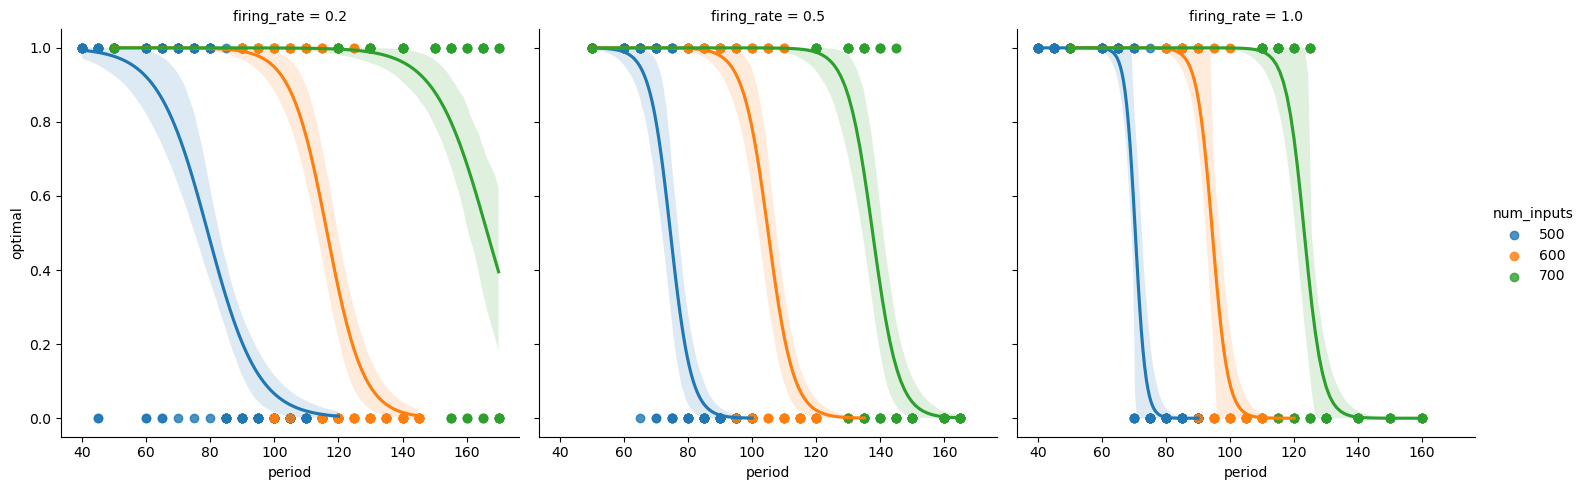

In [23]:
filtered = df_network[(df_network['firing_rate'] < 2.0) & (df_network['num_inputs'].isin([500,600,700])) & (df_network['num_neurons'] == 200) & (df_network['objective'] == "l2") & (df_network['min_slope'] == 2.0) & (df_network['max_level'] == 0.0) & (df_network['lim_weight'] == 0.2)]
sns.lmplot(data=filtered, x='period', y='optimal', hue='num_inputs', logistic=True, col='firing_rate')

# Number of Constraints, Period, and Firing Rate

In [62]:
filtered = df_network[(df_network['firing_rate'] == 0.2) & df_network['optimal'] & (df_network['num_inputs'] == 700) & (df_network['num_neurons'] == 200) & (df_network['objective'] == "l2") & (df_network['min_slope'] == 2.0) & (df_network['max_level'] == 0.0) & (df_network['lim_weight'] == 0.2)]
clf = LinearRegression().fit(filtered[["period"]], filtered["constraints"])

print(clf.coef_, clf.intercept_)

[1.25143161] -14.888537995915925


<Axes: xlabel='period', ylabel='constraints'>

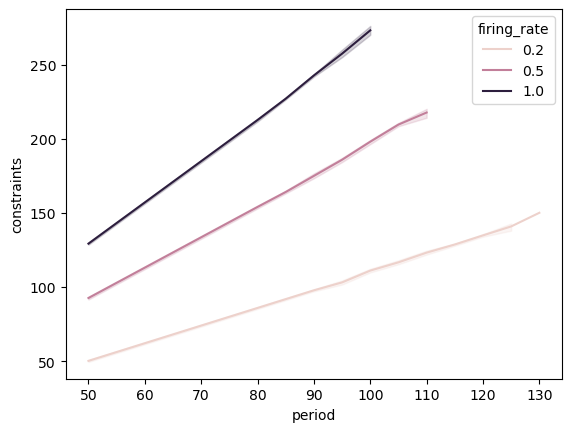

In [58]:
filtered = df_network[(df_network['firing_rate'] < 2.0) & (df_network['period'] >= 50.0) & (df_network['num_inputs'] == 600) & (df_network['num_neurons'] == 200) & (df_network['objective'] == "l2") & (df_network['min_slope'] == 2.0) & (df_network['max_level'] == 0.0) & (df_network['lim_weight'] == 0.2)]
sns.lineplot(filtered, x='period', y='constraints', hue='firing_rate')

<Axes: xlabel='period', ylabel='final_cost'>

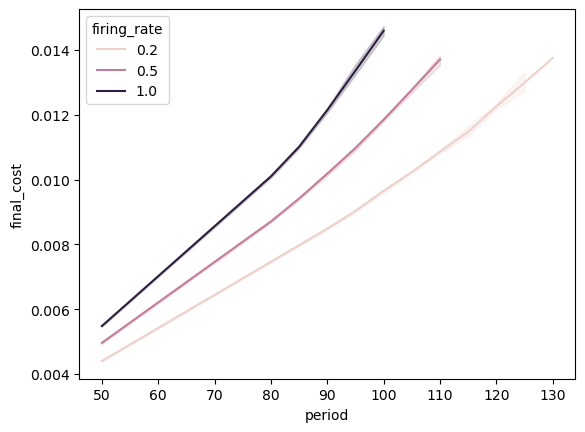

In [59]:
filtered = df_network[(df_network['firing_rate'] < 2.0) & (df_network['period'] >= 50.0) & (df_network['num_inputs'] == 600) & (df_network['num_neurons'] == 200) & (df_network['objective'] == "l2") & (df_network['min_slope'] == 2.0) & (df_network['max_level'] == 0.0) & (df_network['lim_weight'] == 0.2)]
sns.lineplot(filtered, x='period', y='final_cost', hue='firing_rate')